In [1]:
batch_size = 16

## Load the data

In [2]:
import os
import torch
import pandas as pd
import numpy as np
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.nn.functional import one_hot


class CustomImageDataset(Dataset):
    def __init__(self, img_dir, annotations_file = None, transform=None, target_transform=None):
        self.annotations_file = annotations_file
        self.img_labels = pd.read_csv(annotations_file) if (annotations_file != None) else None
        self.img_dir = img_dir
        self.file_names = os.listdir(img_dir)
        self.file_names.sort()
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels) if self.annotations_file != None else len(self.file_names)

    def __getitem__(self, idx):
        if self.annotations_file != None:
            img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        else:
            img_path = os.path.join(self.img_dir, self.file_names[idx])
        image = torch.as_tensor(np.load(img_path))
        image = image.unsqueeze(0)
        
        label = one_hot(torch.as_tensor(self.img_labels.iloc[idx, 1]-1),5).unsqueeze(0).to(torch.float) if (self.annotations_file != None) else self.file_names[idx].split(".")[0]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
val_set = CustomImageDataset("preprocessed_no_silence/val/specs","preprocessed_no_silence/val/labels.csv")
train_set = CustomImageDataset("preprocessed_no_silence/train/specs", "preprocessed_no_silence/train/labels.csv")
test_set = CustomImageDataset("preprocessed_no_silence/test/specs")

In [4]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

## Import libraries

### Model Architecture
1. **Convolutional Layers:**
   - `self.conv1`: The first convolutional layer takes the input (RGB images) and produces feature maps with 16 output channels. The kernel size is set to 3 and padding needs to be 1 to keep the input dimension.
   - `self.conv2`: The second convolutional layer takes the output of the first after the activation funtion and pooling are applied and produces a feature map with 32 channels, and has the the same kernel size and padding (3 and 1).
   - `self.conv3`: The third convolutional layer further increases the number of output channels to 64.

2. **Activation and Pooling:**
   - `self.relu`: Rectified Linear Unit (ReLU) activation function is applied after each convolutional layer to introduce non-linearity.
   - `self.pool`: Max-pooling layer with a kernel size of 2 and a stride of 2 is used to downsample the spatial dimensions.

3. **Fully Connected Layers:**
   - `self.fc1`: The first fully connected layer takes the flattened output from the last convolutional layer and maps it to 64 units.
   - `self.fc2`: The final fully connected layer maps the 64 units to the output space with 10 units, corresponding to the number of classes in CIFAR-10.

### Forward Pass
The `forward` method defines the forward pass of the model. It specifies how input data flows through the layers to produce the final output. Convolutional and pooling layers are followed by activation functions, and the fully connected layers provide the classification logits. Note that the same relu and pooling layers are used in several parts. That is ok as these layers do not have parameters and are only applying the same function to any input, so no separate layers are needed.

This simple CNN serves as a starting point for image classification tasks and can be further customized or extended for more complex problems.


Channel = 1 

Padding = 2 (because dimension is 2) #only use if moving your filter would move you outside the convolution, so it's not mandatory

filter size = width, height and channels (depends on the input size)

Stride = how much you´d have overlap in your steps

Input first layer = 3 

In [5]:
import numpy as np
import os

In [6]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device set to: {device}")

Device set to: cuda


In [7]:
np.load(f"preprocessed_no_silence/train/specs/{os.listdir('preprocessed_no_silence/train/specs')[1]}")

array([[7.0657232e-05, 1.7209392e-04, 2.3501951e-04, ..., 1.7077620e-03,
        1.5036861e-03, 9.1148744e-04],
       [3.8637572e-05, 1.1486666e-04, 1.4416949e-04, ..., 1.1892091e-03,
        1.4038668e-03, 2.2631404e-03],
       [2.4980825e-05, 3.0268208e-04, 7.9013896e-04, ..., 1.0495288e-03,
        1.7465686e-03, 4.0488350e-03],
       ...,
       [4.1200613e-07, 8.0813294e-07, 5.2750320e-06, ..., 1.6070976e-06,
        2.5916790e-06, 9.2446517e-06],
       [2.7452197e-07, 8.4130369e-07, 3.3508848e-06, ..., 1.7964195e-06,
        2.4942694e-06, 9.8216369e-06],
       [4.2310910e-07, 1.4468096e-06, 9.7008424e-06, ..., 1.3897960e-06,
        2.0633490e-06, 8.2167580e-06]], shape=(128, 407), dtype=float32)

In [8]:
# Import necesary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## CNN specification

In [9]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.dropout_prob = 0.5
        
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        # Third Convolutional Layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.convRes1 = nn.Conv2d(in_channels=16, out_channels = 64, kernel_size=1)

        # Fourth Convolutional Layer
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Fifth Convolutional Layer
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        # Dropout Layers
        self.dropout1 = nn.Dropout(self.dropout_prob)
        self.dropout2 = nn.Dropout(self.dropout_prob)
        self.dropout3 = nn.Dropout(self.dropout_prob)
        self.dropout4 = nn.Dropout(self.dropout_prob)
        # self.dropout5 = nn.Dropout(self.dropout_prob)

        # Fully Connected Layers
        fc1_in_features = 51200
        self.fc1 = nn.Linear(in_features=fc1_in_features, out_features=256)
        self.bn2 = nn.BatchNorm1d(num_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.bn3 = nn.BatchNorm1d(num_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.bn4 = nn.BatchNorm1d(num_features=64)
        # self.fc4 = nn.Linear(in_features=64, out_features=32)
        # self.fc5 = nn.Linear(in_features=32, out_features=5)
        self.fc6 = nn.Linear(in_features=64, out_features=5)

        # Output activitation function
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # First Convolutional Block
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Second Convolutional Block
        res = x
        # x = self.dropout1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Third Convolutional Block
        # x = self.dropout1(x)
        x = self.conv3(x)
        # print(x.shape)
        # print(res.shape)
        res = self.convRes1(res)
        # print(res.shape)
        # x += res
        x = self.relu(x)
        x = self.pool(x)

        # Fourth Convolutional Block
        # x = self.dropout1(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool(x)

        # Fifth Convolutional Block
        # x = self.dropout1(x)
        x = self.conv5(x)
        x = self.relu(x)
        
        # Flatten for Fully Connected Layers
        x = x.view(x.size(0), -1)
        
        # Fully Connected Layers
        # print(x.shape)
        x = self.fc1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.fc3(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.dropout1(x)
        # x = self.fc4(x)
        # x = self.relu(x)ze 3325952
        # x = self.dropout4(x)

        x = self.fc6(x)

        # x = self.fc5(x)

        # Output layer
        # x = self.softmax(x)
        
        return x

## Training Loop

In [10]:
# Matplotlib plots using https://stackoverflow.com/questions/37360568/python-organisation-of-3-subplots-with-matplotlib
from torcheval.metrics.aggregation.auc import AUC
from torcheval.metrics.functional import multiclass_f1_score
import matplotlib.gridspec as gridspec
import torch.nn.functional as F

# Training Loop with Validation
def train_model(model, train_loader, val_loader, epochs, criterion, optimizer):
    # Lists to store training and validation losses, and accuracies
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_AUCs = []
    val_AUCs = []    
    train_f1_scores = []
    val_f1_scores = []

    metric = AUC(n_tasks=16)

    best_f1 = 0.0
    best_weights = model.state_dict()
    
    # Loop over epochs
    for epoch in range(epochs):
        # Set the model to training mode
        model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Lists to store true labels and predictions for F1 score
        all_train_labels = []
        all_train_preds = []

        # Training loop        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU if available
            optimizer.zero_grad()

            # Get model outputs
            outputs = model(images)  # Pass the entire batch to the model
            
            # Calculate loss
            # print(labels.view(-1))
            labels = labels.reshape(len(labels),5)
            labels_indices = torch.argmax(labels, dim=1)
            # print(labels.shape)
            # print(labels)
            # print(outputs.shape)
            loss = criterion(outputs, labels_indices)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()

            # Convert logits to probabilities
            outputs_prob = F.softmax(outputs, dim=1)  # Apply softmax to get probabilities

            # Update metrics
            if len(images) == batch_size:
                metric.update(outputs_prob, labels)  # Update AUC with probabilities
        
            for i in range(len(images)):
                output_prob = outputs_prob[i]
                label = labels[i]

                # Get predicted classes
                # print(output_prob)
                _, predicted = torch.max(output_prob, dim=0)

                # Store true labels and predictions for F1 score
                all_train_labels.append(label.cpu())
                all_train_preds.append(predicted.cpu())

                # Store true labels and predictions
                total_train += label.size(0)
                correct_train += (predicted == label).sum().item()  # Count correct predictions

        # Calculate average training loss
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Calculate training accuracy
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Calculate training AUC
        # print(metric.compute())
        train_AUC = metric.compute()
        train_AUCs.append(train_AUC)
        # print(train_AUCs)
        # Reset AUC metric for the next epoch
        metric.reset()

        # Calculate weighted F1 score
        train_f1 = multiclass_f1_score(torch.stack(all_train_preds), torch.stack(all_train_labels).argmax(1), average='weighted', num_classes=5)
        train_f1_scores.append(train_f1.item())

        # Validation loop
        model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        y_true_val = torch.tensor([]).to(device)
        y_pred_val = torch.tensor([]).to(device)
        
        # Lists to store true labels and predictions for F1 score
        all_val_labels = []
        all_val_preds = []

        # Validation without gradient computation
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)  # Move to GPU if available
                
                val_outputs = model(val_images)  # Pass the entire batch to the model

                # Calculate loss
                val_labels = val_labels.reshape(len(val_labels),5)
                val_labels_indices = torch.argmax(val_labels, dim=1)
                # print(labels.shape)
                # print(labels)
                # print(outputs.shape)
                val_loss = criterion(val_outputs, val_labels_indices)
                total_val_loss += val_loss.item()

                # Convert logits to probabilities
                val_outputs_prob = F.softmax(val_outputs, dim=1)  # Apply softmax to get probabilities

                # Update metrics
                if len(val_images) == batch_size:
                    metric.update(val_outputs_prob, val_labels)  # Update AUC

                # Get predicted classes
                _, predicted_val = torch.max(val_outputs_prob, 1)

                # Store true labels and predictions
                total_val += val_labels.size(0)
                for i in range(len(val_images)):
                    val_output_prob = val_outputs_prob[i]
                    val_label = val_labels[i]

                    # Get predicted classes
                    # print(output_prob)
                    _, predicted_val = torch.max(val_output_prob, dim=0)

                    all_val_labels.append(val_label.cpu())
                    all_val_preds.append(predicted_val.cpu())

                    # Store true labels and predictions
                    total_val += val_label.size(0)
                    # print(correct_val)
                    # print(predicted_val.shape)
                    # print(val_label.shape)
                    correct_val += (predicted_val == val_label).sum().item()  # Count correct predictions

        # Calculate average validation loss
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Calculate validation accuracy
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Calculate validation AUC
        val_AUC = metric.compute()
        val_AUCs.append(val_AUC)

        # Reset AUC metric for the next epoch
        metric.reset()

        # Calculate weighted F1 score for training
        val_f1 = multiclass_f1_score(torch.stack(all_val_preds), torch.stack(all_val_labels).argmax(1), average='weighted', num_classes=5)
        if val_f1 > best_f1:
            best_weights = model.state_dict()
            best_f1 = val_f1
        val_f1_scores.append(val_f1.item())

        # print(type(avg_train_loss), avg_train_loss)
        # print(type(train_accuracy), train_accuracy)
        # print(type(avg_val_loss), avg_val_loss)
        # print(type(val_accuracy),val_accuracy)
        # print(type(train_AUC), train_AUC.mean().item())
        # print(type(val_AUC), val_AUC.mean().item())


        # Print progress
        print(f'Epoch [{epoch+1}/{epochs}], '
              f'Train - loss: {avg_train_loss:.4f}, acc: {train_accuracy * 100:.2f}%, AUC: {train_AUC.mean().item():.3f}, F1: {train_f1:.3f}; '
              f'Validation - loss: {avg_val_loss:.4f}, acc: {val_accuracy * 100:.2f}%, AUC: {val_AUC.mean().item():.3f}, F1: {val_f1:.3f}')
    
    # Plotting the loss, accuracy, AUC, and F1 score over epochs
    gs = gridspec.GridSpec(3, 2)  # Create a 3x2 grid
    plt.figure(figsize=(12, 12))

    # Plot Training and Validation Loss
    ax = plt.subplot(gs[0, 0])  # row 0, col 0
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Plot Training and Validation Accuracy
    ax = plt.subplot(gs[0, 1])  # row 0, col 1
    plt.plot(train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Epochs')
    plt.legend()

    # # Plot Training and Validation AUC
    # ax = plt.subplot(gs[1, 0])  # row 1, col 0
    # plt.plot([train_AUC.cpu() for train_AUC in train_AUCs], label='Training AUC', color='blue')
    # plt.plot([val_AUC.cpu() for val_AUC in val_AUCs], label='Validation AUC', color='orange')
    # plt.xlabel('Epoch')
    # plt.ylabel('AUC')
    # plt.title('AUC over Epochs')
    # plt.legend()

    # Plot Training and Validation F1 Score
    ax = plt.subplot(gs[1, 1])  # row 1, col 1
    plt.plot(train_f1_scores, label='Training F1 Score', color='blue')
    plt.plot(val_f1_scores, label='Validation F1 Score', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 Score over Epochs')
    plt.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

    model.load_state_dict(best_weights)
    print(f"Best F1-score: {best_f1}")
    return val_losses

## Train CNN

Epoch [1/30], Train - loss: 1.7250, acc: 15.77%, AUC: 0.123, F1: 0.184; Validation - loss: 1.5728, acc: 12.82%, AUC: 0.043, F1: 0.173
Epoch [2/30], Train - loss: 1.6557, acc: 18.46%, AUC: 0.161, F1: 0.225; Validation - loss: 1.5272, acc: 22.30%, AUC: 0.087, F1: 0.309
Epoch [3/30], Train - loss: 1.5898, acc: 22.52%, AUC: 0.226, F1: 0.288; Validation - loss: 1.4859, acc: 21.33%, AUC: 0.118, F1: 0.309
Epoch [4/30], Train - loss: 1.5248, acc: 24.89%, AUC: 0.285, F1: 0.306; Validation - loss: 1.4178, acc: 29.15%, AUC: 0.287, F1: 0.370
Epoch [5/30], Train - loss: 1.4588, acc: 25.59%, AUC: 0.367, F1: 0.347; Validation - loss: 1.3211, acc: 23.17%, AUC: 0.446, F1: 0.397
Epoch [6/30], Train - loss: 1.3806, acc: 25.77%, AUC: 0.454, F1: 0.396; Validation - loss: 1.2704, acc: 23.25%, AUC: 0.485, F1: 0.464
Epoch [7/30], Train - loss: 1.3525, acc: 25.52%, AUC: 0.459, F1: 0.416; Validation - loss: 1.2965, acc: 27.51%, AUC: 0.457, F1: 0.418
Epoch [8/30], Train - loss: 1.2864, acc: 24.66%, AUC: 0.504, F

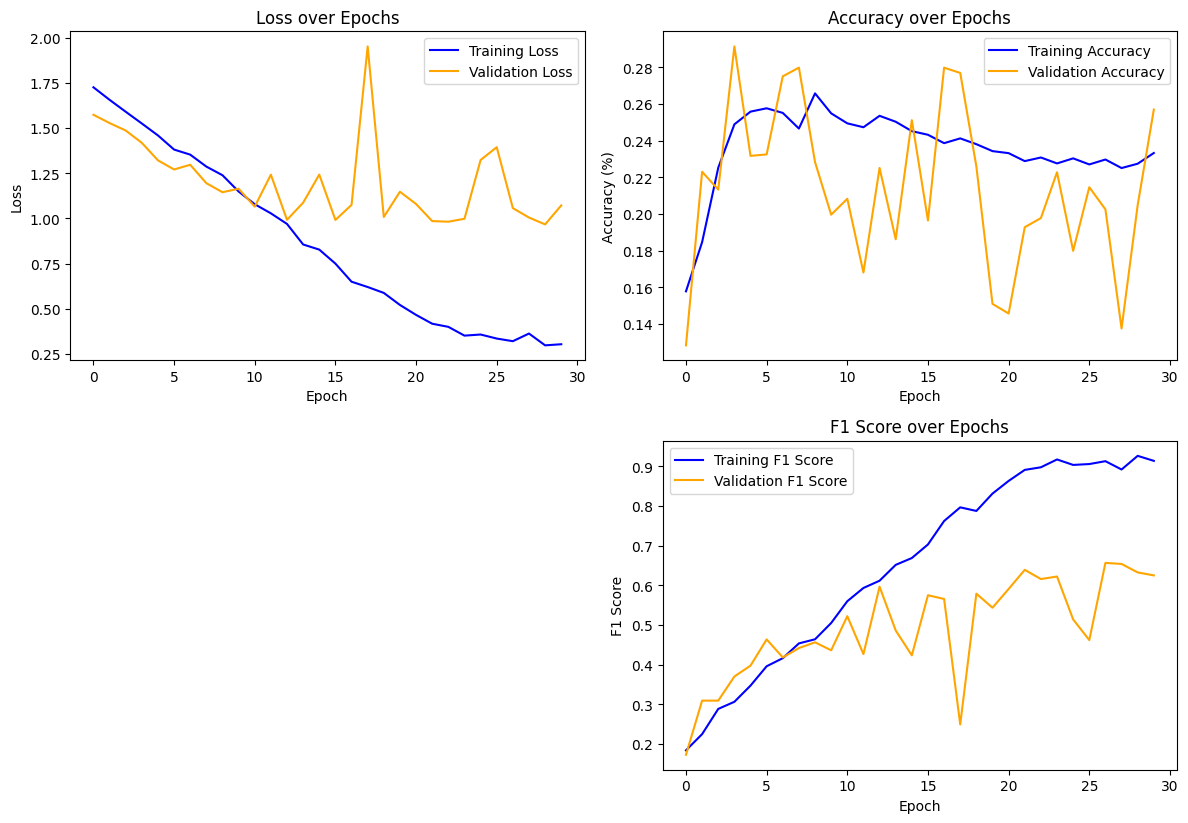

Best F1-score: 0.6566990613937378


In [11]:
from torcheval.metrics.aggregation.auc import AUC

# Setting Hyperparameters and Training the Model

# Number of training epochs
epochs = 30
# Create an instance of the SimpleCNN model and move it to the specified device (GPU if available)
model = SimpleCNN().to(device)

# Define the loss criterion (CrossEntropyLoss) and the optimizer (Adam) for training the model
weights = torch.tensor([0.17768543*5, 0.1938815*5, 0.20993698*5, 0.14523569*5, 0.2732604*5]).to(device) # Weighted based on data availability (see 1 Data Analysis.ipynb)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model using the defined training function
val_losses_simple = train_model(model, train_loader, val_loader, epochs, criterion, optimizer)

## Predict test set

In [12]:
df_test = pd.DataFrame()
with torch.no_grad():
    model.eval()
    ids = []
    pred_labels = []
    for images, labels in test_loader:
        images = images.to(device)  # Move to GPU if available

        # Get model outputs
        outputs = model(images)  # Pass the entire batch to the model
        
        test_outputs_prob = F.softmax(outputs, dim=1)

        ids += labels
        pred_labels += [output.item()+1 for output in test_outputs_prob.argmax(dim=1)]
    # print(len(pred_labels), pred_labels)
    df_test["Id"] = ids
    df_test["label"] = pred_labels
    # for output in df_test["label"]:
    #     print(output)
df_test.to_csv("preprocessed/test/labels.csv",index=False)
df_test

,Id,label
0,1035,3
1,1074,4
2,1088,3
3,1095,3
4,1099,4
...,...,...
546,9949,3
547,9954,1
548,9959,4
549,9974,4


## Regularization techniques

one widely used regularization technique is called Drouppout. Iirc, it systematically deactivates some neurons during training to make the model more robust for when the test data doesn't have some parts of the expected pattern. (I've implmented that below, but if we decide to use something else, then that's also fine.)

More possible techniques: 
- early stopping (would be nice if model overfits)
- L1 or L2 regularization (makes weights smaller/less of them) (affects the los function)

In [13]:
##NN with dropout

class SimpleCNN_with_dropout(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(SimpleCNN_with_dropout, self).__init__()

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        # Third Convolutional Layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Fourth Convolutional Layer
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Fifth Convolutional Layer
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        #Dropouts
        self.dropout1 = nn.Dropout(dropout_prob)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.dropout3 = nn.Dropout(dropout_prob)
        self.dropout4 = nn.Dropout(dropout_prob)
        self.dropout5 = nn.Dropout(dropout_prob)

        # Fully Connected Layers
        fc1_in_features = 256 * 8 * 25
        self.fc1 = nn.Linear(in_features=fc1_in_features, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=32)
        self.fc5 = nn.Linear(in_features=32, out_features=5)

    def forward(self, x):
        # First Convolutional Block
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        # Dropout applied after the first convolutional layer
        x = self.dropout1(x)
        
        # Second Convolutional Block
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        # Dropout applied after the second convolutional layer
        x = self.dropout2(x)
        
        # Third Convolutional Block
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)

        # Dropout applied after the third convolutional layer
        x = self.dropout3(x)

         # Fourth Convolutional Block
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool(x)

        # Dropout applied after the fourth convolutional layer
        x = self.dropout4(x)

        # Fifth Convolutional Block
        x = self.conv5(x)
        x = self.relu(x)

        # Dropout applied after the fifth convolutional layer
        x = self.dropout5(x)
        
        # Flatten for Fully Connected Layers
        x = x.view(-1, self.fc1.in_features)
        
        # Fully Connected Layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        
        return x


In [14]:
#Train CNN with drouput
epochs = 100
model_d = SimpleCNN_with_dropout(dropout_prob=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_d.parameters(), lr=0.001)
val_losses_dropout = train_model(model_d, train_loader, val_loader, epochs, criterion, optimizer)

Epoch [1/100], Train - loss: 1.6271, acc: 17.28%, AUC: 0.128, F1: 0.182; Validation - loss: 1.5974, acc: 0.00%, AUC: 0.018, F1: 0.093
Epoch [2/100], Train - loss: 1.5831, acc: 35.17%, AUC: 0.257, F1: 0.189; Validation - loss: 1.5090, acc: 26.96%, AUC: 0.330, F1: 0.238
Epoch [3/100], Train - loss: 1.4829, acc: 30.01%, AUC: 0.452, F1: 0.275; Validation - loss: 1.6906, acc: 51.63%, AUC: 0.241, F1: 0.192
Epoch [4/100], Train - loss: 1.4103, acc: 27.14%, AUC: 0.484, F1: 0.311; Validation - loss: 1.6109, acc: 40.86%, AUC: 0.267, F1: 0.234
Epoch [5/100], Train - loss: 1.3658, acc: 25.26%, AUC: 0.476, F1: 0.330; Validation - loss: 1.3464, acc: 28.01%, AUC: 0.434, F1: 0.291
Epoch [6/100], Train - loss: 1.3453, acc: 26.66%, AUC: 0.475, F1: 0.365; Validation - loss: 1.3937, acc: 28.04%, AUC: 0.348, F1: 0.265
Epoch [7/100], Train - loss: 1.2670, acc: 28.53%, AUC: 0.482, F1: 0.405; Validation - loss: 1.3247, acc: 28.67%, AUC: 0.384, F1: 0.376
Epoch [8/100], Train - loss: 1.2599, acc: 28.08%, AUC: 0

KeyboardInterrupt: 

Why use the parameters we use?

Adam optimizer
- generally concidered the best optimizer
- implements both momentum and adaptive learning rate
    - adaptive learning rate: each parameter gets it's own learning rate which helps with finding the minimum for the cost function connected to that secific parameter
    - momentum: accelerates convergence (finding the minimum faster) because it accumulates information about past gradients (ie: it makes the process faster) and also allows the model not to get stuck in local minima as often

Hyperparameters for Adam
- Beta for momentum: defalut
- Beta for  average square gradient: defalut
- initial learning rate: 0.001
- hyperparameter tuning:
    - none yet

Regularization techniques
- allows for beter generalizability
    - network doesn't rely on specific neutrons too much
- reduces overfitting